## Schizophrenia Connectivity Investigation

Purpose:
Author: K20002990
Date Started: 14/11/2023
Date Completed:
Notes:

### Contents
1. [Importing Modules and Loading data](#load-data)
3. [Thresholding](#thresholding)
4. [Compute Random Attacks](#attacks)
5. [Calculate Network Robustness](#robustness_calculations)
6. [Inferential Statistics](#inferential-stats)
6. [Statistical Tests](#stats-tests)
7. [Simulated Plots](#sim-plots)

### Importing Modules and Loading Data <a class="anchor" id="load-data"></a>
- Import all modules and functions that will be used throughout the script
- Load data and organise by assigning variables to the matrices that we will need
- Extract matrices needed for analysis

In [1]:
# Import all librarie modules needed for this script
import matplotlib.pyplot as plt
import matplotlib.colors
from matplotlib.colors import LinearSegmentedColormap
from nilearn import plotting
from nilearn.plotting import find_parcellation_cut_coords

import numpy as np
import networkx as nx
import pandas as pd
import bct as bct

from scipy import stats
from scipy.stats import shapiro
from scipy.stats import mannwhitneyu
from scipy.stats import pearsonr
from scipy.interpolate import make_interp_spline

from pymatreader import read_mat

In [2]:
# Load the .mat file into a dictionary format
data_dict = read_mat('27_SCHZ_CTRL_dataset.mat')

# Look at the keys for the data_dict
data_dict.keys()

c:\Users\hanif\anaconda3\lib\site-packages\pymatreader\utils.py:124: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '


dict_keys(['#subsystem#', 'SC_FC_Connectomes'])

In [3]:
# Select the relevant key 
dict_key = 'SC_FC_Connectomes'

# Look at the different data types available
data_dict[dict_key].keys()

dict_keys(['SC_density', 'SC_ADC', 'demographics', 'SC_length_of_fibers', 'SC_number_of_fibers', 'FC_correlation', 'SC_gFA'])

In [4]:
# Create function that loops over mat file to extract connetcome matrices into single variable
def extract_matrix(mat_dict: dict, resolution: int,  n_sub: int, dict_key: str, data_type: str, variable_group: str):

    """
    Extracts matrices from dictionary and returns a 3d matrix for a group of participants
    
    Args:
        mat_dict: Dictionary containing data
        n_sub: Number of subjects in the variable group
        data_type: data to be extracted
        variable_group: Control or Schizophrenia (ctrl or schz)
        resolution: Resolution for number of regions of interest
        
    Returns:
        3D Matrix of participant data for selected group, with the shape (resolution, resolution, n_participants)
        
    """

    # Resolutions and their relative indices based on README file
    resolution_dict = {83: 0, 129: 1, 234: 2, 463: 3, 1015: 4}

    # Initialise empty matrix
    correlation_matrices = np.zeros((resolution, resolution, n_sub))
    
    # Loop through participants different matrices and extract the matrix for the chosen resolution
    for i in range(n_sub):
        
        # Extract the correlation matrix for the i-th participant
        correlation_matrix = mat_dict[dict_key][data_type][variable_group][resolution_dict[resolution]][:,:,i]
        
        # Append the correlation matrix to the list
        correlation_matrices[:,:,i] = correlation_matrix

    return correlation_matrices

In [5]:
# Define resolution, data type and number of participants
resolution = 83                 # Chosen resolution to look at
data_type = 'FC_correlation'    # Chosen data type to analyse

n_schz_subjects = 27            # Number of subjects with Schizophrenia
n_ctrl_subjects = 27            # Number of controld subjects

# Get the functional connectivity matrices for schz and ctrl into separate variables
FC_schz_cormat = extract_matrix(data_dict, resolution, n_schz_subjects, dict_key,  data_type, 'schz')
FC_ctrl_cormat = extract_matrix(data_dict, resolution, n_ctrl_subjects, dict_key, data_type, 'ctrl')

### Thresholding <a class="anchor" id="thresholding"></a>

Take the absolute values for connectivity matrices and threshold all connectivity matrices to be above a specified value

In [6]:
# Create a function that thresholds all matrix values
def threshold(matrix, threshold_value: float):

    """

    Applies threshold onto each participant matrix, taking only the strongest edges above the specific threshold

    Args:
        matrix: 3D matrix where the shape is (roi, roi, number of participants)
        threshold_percent: A positive decimal to threshold
    
    Returns:
        3D matrix containing all thresholded matrices on a scale of 0 to 1. The shape is (rois, rois, number of participants)

    """

    n_sub = matrix.shape[2]         # Number of participants/ subjects
    n_rois = matrix.shape[0]        # Number of regions of interest
    
    # Initialise 3D matrix to store thresholded values
    all_thresholded_cormats = np.zeros((n_rois, n_rois, n_sub))

    # For loop that thresholds matrices one participant at a time
    for i in range(n_sub):
        cormat = matrix[:,:,i]      # Get matrix for single participant

        # Take the absolute values of the matrix, to get weights on scale of 0 to 1
        abs_cormat = np.abs(cormat)

        # Threshold matrix to only include the weights above the threshold
        thresholded_cormat = np.where(abs_cormat > threshold_value, abs_cormat, 0)

        all_thresholded_cormats[:,:,i] = thresholded_cormat     # Store in 3D matrix
    
    return all_thresholded_cormats


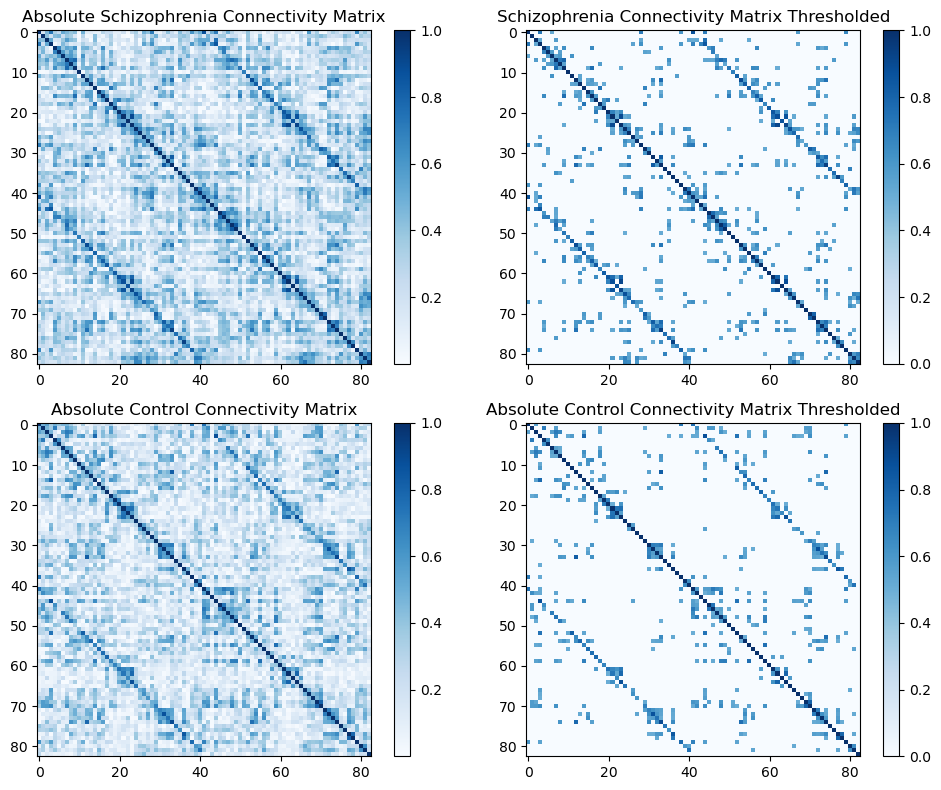

In [58]:
# Define edge threshold 
threshold_value = 0.5 # Get 35% of strongest edges

# Apply the threshold to correlation matrix
schz_cormat_thresholded = threshold(FC_schz_cormat, threshold_value)
ctrl_cormat_thresholded = threshold(FC_ctrl_cormat, threshold_value)

# Create a figure with 2 subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

example_participant = 20

# Plot the first matrix : SCHZ unthresholded
axs[0, 0].imshow(np.abs(FC_schz_cormat[:,:,example_participant]), cmap = 'Blues')
axs[0, 0].set_title('Absolute Schizophrenia Connectivity Matrix')
fig.colorbar(axs[0, 0].imshow(np.abs(FC_schz_cormat[:,:,example_participant]), cmap = 'Blues'), ax=axs[0, 0])

# Plot the second matrix : SCHZ thresholded
axs[0, 1].imshow(schz_cormat_thresholded[:,:,example_participant], cmap = 'Blues')
axs[0, 1].set_title('Schizophrenia Connectivity Matrix Thresholded')
fig.colorbar(axs[0, 1].imshow(schz_cormat_thresholded[:,:,example_participant], cmap = 'Blues'), ax=axs[0, 1])

# Plot the third matrix : CTRL unthresholded
axs[1, 0].imshow(FC_ctrl_cormat[:,:,example_participant], cmap = 'Blues')
axs[1, 0].set_title('Absolute Control Connectivity Matrix')
fig.colorbar(axs[1, 0].imshow(np.abs(FC_ctrl_cormat[:,:,example_participant]), cmap = 'Blues'), ax=axs[1, 0])

# Plot the fourth matrix : CTRL thresholded
axs[1, 1].imshow(ctrl_cormat_thresholded[:,:,example_participant], cmap = 'Blues')
axs[1, 1].set_title('Absolute Control Connectivity Matrix Thresholded')
fig.colorbar(axs[1, 1].imshow(ctrl_cormat_thresholded[:,:,example_participant], cmap = 'Blues'), ax=axs[1, 1])

plt.tight_layout()
plt.style.use('default')
# Show the plots
plt.show()


In [8]:
## This cell may take a little while to run ##

# Extract coords for connectome plots
coords = find_parcellation_cut_coords('ROI_scale33.nii.gz')

In [45]:
# Create function that plots two connectomes, one below the other, showing a before and after thresholding
def plot_connectomes(cormat, cormat_thresholded, participant, coords, color, darker_color):
    
    # Define the range of colors for edges
    cmap_colors = ['white', color]

    # Create the colormap for edges to use
    cmap = LinearSegmentedColormap.from_list('my_cmap', cmap_colors)

    # create a figure with two subplots
    fig, ax = plt.subplots(2, 1)

    # plot the first connectome on the top left subplot
    plotting.plot_connectome(cormat[:,:,participant],       # connectome
                             node_coords=coords,            # node coordinates
                             node_color=darker_color,       # node colors
                             edge_cmap = cmap,              # edge cmap color
                             node_size=7,                   # node sizes
                             edge_kwargs={'alpha':1, 'linewidth': 0.05},    # edge transparency and line width
                             axes=ax[0])                    # subplot handle
    ax[0].set_title('Original Connectome')                  # add title

    # plot the second connectome on the bottom left subplot
    plotting.plot_connectome(cormat_thresholded[:,:,participant], 
                             node_coords=coords, 
                             node_color=darker_color, 
                             edge_cmap = cmap,
                             node_size=7, 
                             edge_kwargs={'alpha': 1, 'linewidth': 0.2},
                             axes=ax[1]) 
    ax[1].set_title('Thresholded Connectome')

    plt.show()


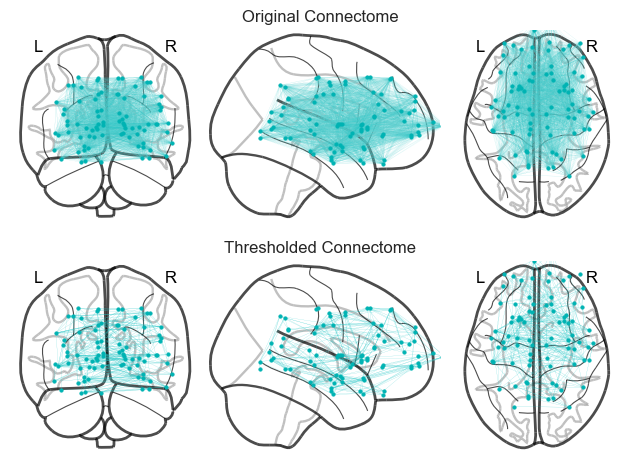

In [41]:
# Plot schz before and after thresholding connectomes
plot_connectomes(FC_schz_cormat, schz_cormat_thresholded, example_participant, coords, 'c', '#00b3b3')

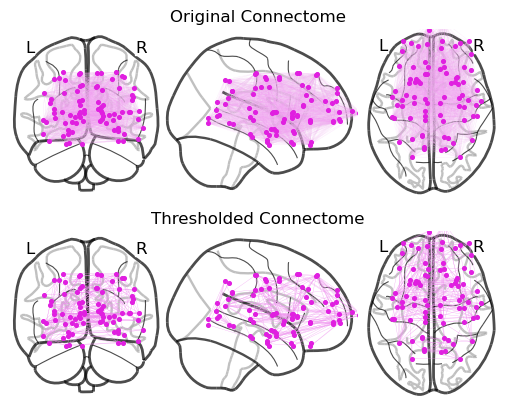

In [46]:
# Plot controls before and after thresholding connectomes
plot_connectomes(FC_ctrl_cormat, ctrl_cormat_thresholded, example_participant, coords, 'violet', '#e01fe0')

### Compute Random Attacks <a class="anchor" id="attacks"></a>

Simulate random attacks on participants' networks and record the largest component sizes

In [12]:
# Create function that calculates the largest component size of a network
def largest_component_size(graph):
  """
  Takes the sizes of components and calculates the largest component size of the given network

  Args: 
    graph: Network X graph representing thresholded brain network
  
  Returns:
    The largest component size for the graph parameter

  """
  components = list(nx.connected_components(graph))

  # Find the largest component and get its size
  largest_component = max(components, key=len)
  size = len(largest_component)
  
  # Return the size of the largest component
  return size

# Function that takes simulates attacks on a matrix and calculates largest component size
def simulate_attacks(matrix, max_percent: float, percent_steps: float, return_info = False): 
    
    """
    Simulates attacks on the network by deleting components (nodes) and measures the largest component size after every attack.

    Args:
      matrix: 3D matrix with the shape (roi, roi, number of participants)
      max_percent: Total percentage of nodes to remove
      percent_steps: Percentage of nodes to remove for each attack
      return_info: bool to determine whether user would like to return the accurate fraction of nodes attacked per simulation

    Returns:
      Pandas dataframe where each column is a participant and the rows are the largest component size after simulated attack

    """
    
    # Find total nodes and subjects
    total_nodes = matrix.shape[0]
    n_sub = matrix.shape[2]

    # Find the number of nodes to attack that is approximate to the percentages given
    nodes_to_attack = round(total_nodes * percent_steps) # How many nodes to attack that is approximate to % given
    num_attacks = round(max_percent / percent_steps)     # How many times an attack will occur based on max percentage
    
    # Initialise dictionary to store largest component sizes after each attack
    component_sizes = {}

    # Loop through participants for simulations
    for participant in range(n_sub):

        # Extract single matrix for participant and convert to graph
        cormat = matrix[:,:,participant]  
        graph = nx.Graph(cormat)          

        # Initialise list for participant key in component_sizes dictionary, first item is largest component size before any attacks.
        component_sizes[f"participant {participant+1}"] = [largest_component_size(graph)]

        # Nested for loop to simulate attacks, calculating largest component size after each attack
        for attack in range(num_attacks):
            
            # Randomly select nodes to remove
            nodes_to_remove = np.random.choice(graph.nodes, size=nodes_to_attack, replace=False)
            
            # Remove the nodes from the graph
            graph.remove_nodes_from(nodes_to_remove)

            # Calculate the largest component size value from the network after attack
            largest_component = largest_component_size(graph)

            # Store the largest component size in dict by appending the list assigned to each participant
            component_sizes[f"participant {participant+1}"].append(largest_component)
    
    # Convert dict to a pandas dataframe 
    component_sizes_df = pd.DataFrame(component_sizes)

    # Find number of nodes attacked and fraction of nodes attacked (attack_info)
    n_nodes_attacked = [(nodes_to_attack * i) for i in range(0, num_attacks+1)]
    attack_info = [(nodes_to_attack * i)/total_nodes for i in range(0, num_attacks+1)]

    # Set the row names (index)
    component_sizes_df.index = [f'{round(i/total_nodes, 2)*100}% nodes removed' for i in n_nodes_attacked]

    if return_info == True:
      return attack_info, component_sizes_df
    else:
      return component_sizes_df
            

In [13]:
## DO NOT RUN MORE THAN ONCE - WILL LEAD TO DIFFERENT RESULTS ##

percentage_node_attack = 0.5            # Total % nodes to attack
percentage_step_node_attack = 0.1       # % of nodes to attack for each simulation

# Simulate attacks for both groups. x_values only needed once, as they are the same across groups
x_values, schz_attacks = simulate_attacks(schz_cormat_thresholded, percentage_node_attack, percentage_step_node_attack, return_info = True)
ctrl_attacks = simulate_attacks(ctrl_cormat_thresholded, percentage_node_attack, percentage_step_node_attack)

# Check the tables to see if attacks have been simulated correctly
# We expect the largest component size values to either stay the same or decrease per attack
print('Schizophrenia Attacks:\n', schz_attacks.iloc[:,:3])
print('\nControl Attacks:\n',ctrl_attacks.iloc[:,:3])

print(f'\nx values (fraction of nodes attacked): \n{x_values}')

Schizophrenia Attacks:
                                    participant 1  participant 2  participant 3
0.0% nodes removed                            75             71             75
10.0% nodes removed                           69             65             68
19.0% nodes removed                           60             56             61
28.999999999999996% nodes removed             53             49             51
39.0% nodes removed                           47             42             44
48.0% nodes removed                           36             32             35

Control Attacks:
                                    participant 1  participant 2  participant 3
0.0% nodes removed                            80             78             79
10.0% nodes removed                           72             67             70
19.0% nodes removed                           64             59             63
28.999999999999996% nodes removed             56             52             52
39.0% nod

### Calculate Network Robustness <a class="anchor" id="robustness_calculations"></a>

Plot largest component sizes against fraction of nodes attacked to calculate network robustness

In [14]:
# Function to calculate area under the curve for each column
def calculate_area(y_values: pd.DataFrame, x_values: list):
    
    """
    Calculates the area under the estimated curve per participant and stores in a list
    
    Args:
        y_values: A pandas dataframe where each column is a set of y values for every participant
        x_values: List of x values 

    Returns:
        List containing the robustness calculations for each participant

    """

    return [np.trapz(y_values[column], x_values) for column in y_values.columns]

In [15]:
# Combine data into single pandas dataframe
robustness_df = pd.DataFrame({
    'Schizophrenia Robustness': calculate_area(schz_attacks, x_values),
    'Control Robustness': calculate_area(ctrl_attacks, x_values)
})

# Check the df is in the structure we expect (groups as columns and participants as rows)
print(robustness_df.head())

   Schizophrenia Robustness  Control Robustness
0                 27.421687           28.915663
1                 25.397590           26.602410
2                 26.891566           27.951807
3                 26.939759           29.397590
4                 22.746988           26.987952


### Inferential Statistics <a class="anchor" id="inferential-stats"></a>

Conduct inferential statistics and plot informational graphs

In [16]:
# Split dataframe for ease of plotting
schz_robust = robustness_df['Schizophrenia Robustness']
ctrl_robust = robustness_df['Control Robustness']


Group 1:
Median = 26.99
IQR = 2.27

Group 2:
Median = 27.42
IQR = 1.59


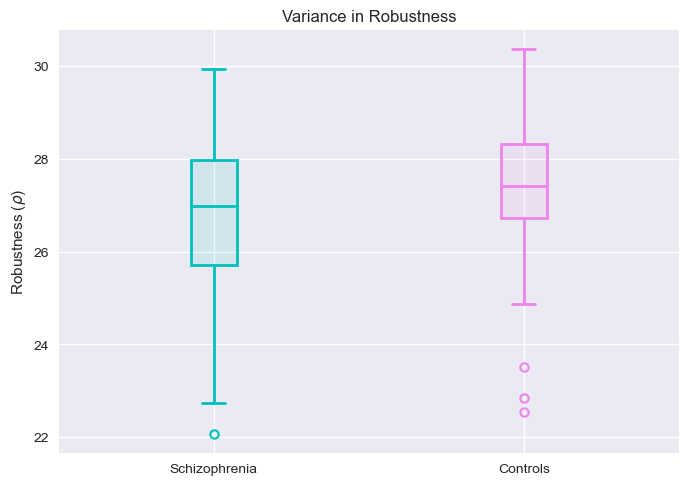

In [56]:
## Make line thicker ##
# Create a boxplot showing the means and distributions of robust values for each group
fig, ax = plt.subplots()
bp = ax.boxplot(robustness_df, patch_artist=True) # plot boxplot and prepare for customisations

# Define colors to use
fillcol1 = matplotlib.colors.to_rgba('c', alpha=0.1)
fillcol2 = matplotlib.colors.to_rgba('violet', alpha=0.1)

# Define fill and edge colours
fill_colors = [fillcol1, fillcol2]
edge_colors = ['c', 'violet']

# Boxplot line width
line_width = 2

# Iterate through each group and change the colours of the boxplots and outliers
for i in range(len(bp['boxes'])):

    # Boxes
    bp['boxes'][i].set_facecolor(fill_colors[i])
    bp['boxes'][i].set_edgecolor(edge_colors[i])
    bp['boxes'][i].set_linewidth(line_width)

    # Medians
    bp['medians'][i].set_color(edge_colors[i])
    bp['medians'][i].set_linewidth(line_width)

    # Whiskers
    bp['whiskers'][i*2].set_color(edge_colors[i])
    bp['whiskers'][i*2].set_linewidth(line_width)
    bp['whiskers'][i*2 + 1].set_color(edge_colors[i])
    bp['whiskers'][i*2 + 1].set_linewidth(line_width)

    # Caps
    bp['caps'][i*2].set_color(edge_colors[i])
    bp['caps'][i*2].set_linewidth(line_width)
    bp['caps'][i*2 + 1].set_color(edge_colors[i])
    bp['caps'][i*2 + 1].set_linewidth(line_width)
    

    # Fliers (outliers)
    bp['fliers'][i].set_markeredgecolor(edge_colors[i])
    bp['fliers'][i].set_markeredgewidth(1.5)

# Add a plot title
ax.set_title('Variance in Robustness')

# Add x and y labels
ax.set_xticklabels(['Schizophrenia', 'Controls']) 
ax.set_ylabel(r'Robustness ($\rho$)')

# Change the style
plt.style.use('seaborn')

# Print the medians and IQRs
for i, s in enumerate(bp['medians']):
    print(f"\nGroup {i+1}:")
    print(f"Median = {round(s.get_ydata()[0], 2)}")
    # Get the path object of the box
    path = bp['boxes'][i].get_path()
    # Get the vertices of the path
    vertices = path.vertices
    # Get the y-coordinates of the vertices
    ydata = vertices[:, 1]
    # Calculate the IQR from the y-coordinates
    iqr = ydata[2] - ydata[0]
    print(f"IQR = {round(iqr, 2)}")


plt.show()

In [52]:
# Obtain the mean and sd of largest component value for each attack in both groups
schz_component_stats = schz_attacks.agg(['mean', 'std'], axis=1)
ctrl_component_stats = ctrl_attacks.agg(['mean', 'std'], axis=1)

# Check the output is as expected
print(schz_component_stats)
print(ctrl_component_stats)

                                        mean       std
0.0% nodes removed                 76.962963  3.767079
10.0% nodes removed                68.666667  3.430631
19.0% nodes removed                60.851852  3.404790
28.999999999999996% nodes removed  52.148148  4.329716
39.0% nodes removed                41.814815  7.519396
48.0% nodes removed                33.037037  8.040673
                                        mean       std
0.0% nodes removed                 77.592593  3.532914
10.0% nodes removed                69.481481  3.412312
19.0% nodes removed                60.740741  3.590507
28.999999999999996% nodes removed  51.777778  5.213395
39.0% nodes removed                43.888889  5.301185
48.0% nodes removed                34.740741  7.299065


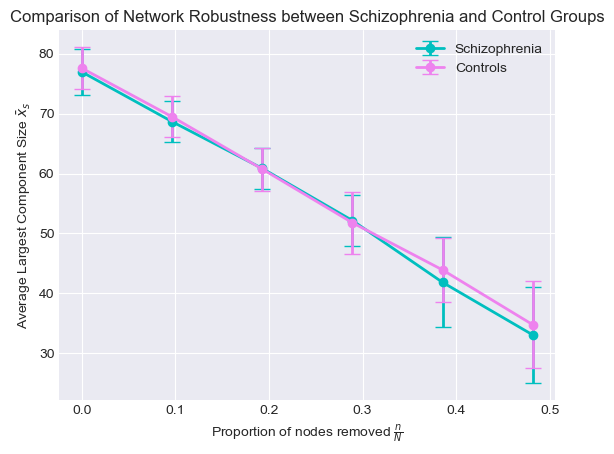

In [19]:
# Calculate the means and sd for the largest component value in each group and plot on line graph

# plot for schz
plt.errorbar(x_values,                          # x values
             schz_component_stats['mean'],      # y values
             schz_component_stats['std'],       # error bar values
             fmt='o-',                          # plotted point shape
             color=edge_colors[0],              # line color
             ecolor= edge_colors[0],            # error bar color
             linewidth=2,                       # line width
             capsize=6)                         # error bar cap size

# plot for controls
plt.errorbar(x_values, 
             ctrl_component_stats['mean'], 
             ctrl_component_stats['std'], 
             fmt='o-', 
             color=edge_colors[1], 
             linewidth=2, 
             capsize=6)

# set style
plt.style.use('seaborn-darkgrid')

# add labels
plt.xlabel(r'Proportion of nodes removed $\frac{n}{N}$')
plt.ylabel(r'Average Largest Component Size $\bar{x}_s$')
plt.title('Comparison of Network Robustness between Schizophrenia and Control Groups')
plt.legend(['Schizophrenia', 'Controls'])
plt.grid(True)      # add grid

plt.show()

### Statistical Tests <a class="anchor" id="stats-tests"></a>

Test the normality of the data and the differences in robustness between groups

In [20]:
# The data seems to very roughly fit a normal distribution, but just to be sure lets test it

# Perform Shapiro-Wilk test
schz_normal_statistic, schz_normal_pvalue = shapiro(schz_robust)
ctrl_normal_statistic, ctrl_normal_pvalue = shapiro(ctrl_robust)

# Print shapiro values
print('Shapiro Wilk Values:')
print(f'\nSchz Statistic: {round(schz_normal_statistic, 2)} \nSchz P value: {round(schz_normal_pvalue, 2)}')
print(f'\nCtrl Statistic: {round(ctrl_normal_statistic, 2)} \nCtrl P value: {round(ctrl_normal_pvalue, 2)}')

# Interpret results:
normal_alpha = 0.05     # Used for testing normality of data
alpha = 0.05            # Used for statistical tests investigating difference

# Write the possible outcomes in a variable to avoid repeating strings in if statement
reject_null_msg = 'Reject the null hypothesis. There is a significant difference in network robustness between the groups.'
fail_to_reject_null_msg = 'Fail to reject the null hypothesis. There is no significant difference in network robustness between the groups.'

if schz_normal_pvalue < normal_alpha and ctrl_normal_pvalue < normal_alpha:
    print("\nThe data follows a normal distribution, performing t-test..")

    # Perform independent two-sample t-test
    t_statistic, p_value = stats.ttest_ind(schz_robust, ctrl_robust)

    # Print important values
    print(f'U statistic: {t_statistic}')
    print(f'P value: {p_value}')

    if p_value < alpha:
        print(reject_null_msg)
    else:
        print(fail_to_reject_null_msg)

else:
    print("\nThe data does not fit a normal distribution, performing Mann Whitney U test...")

    # Perform the Mann-Whitney U test
    u_statistic, p_value = mannwhitneyu(schz_robust, ctrl_robust)

    # Print important values
    print(f'U statistic: {round(u_statistic, 2)}')
    print(f'P value: {round(p_value, 2)}')

    if p_value < alpha:
        print(reject_null_msg)
    else:
        print(fail_to_reject_null_msg)


Shapiro Wilk Values:

Schz Statistic: 0.96 
Schz P value: 0.34

Ctrl Statistic: 0.93 
Ctrl P value: 0.07

The data does not fit a normal distribution, performing Mann Whitney U test...
U statistic: 322.5
P value: 0.47
Fail to reject the null hypothesis. There is no significant difference in network robustness between the groups.


In [21]:
# Calculate effect size

mean_diff = np.mean(schz_robust) - np.mean(ctrl_robust)
pooled_std_dev = np.sqrt((np.std(schz_robust) ** 2 + np.std(ctrl_robust) ** 2) / 2)
cohens_d = mean_diff / pooled_std_dev

print(f"Cohen's d: {cohens_d}")

Cohen's d: -0.17625673676592418


### Simulated Plots <a class="anchor" id="sim-plots"></a>

Create simulated plots used throughout the research paper to explain concepts

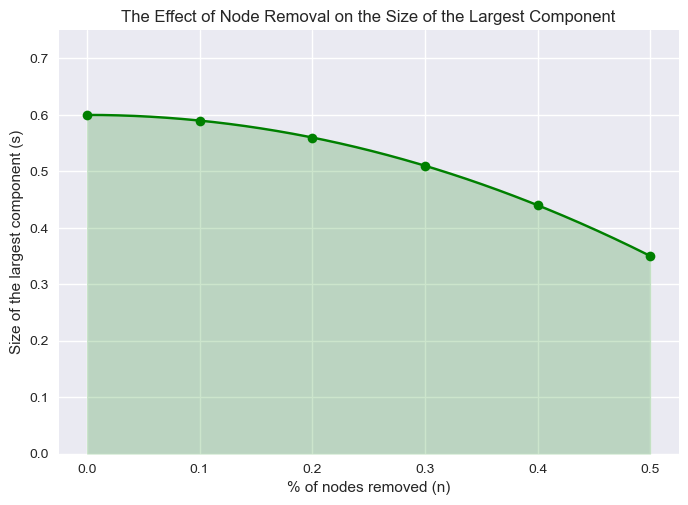

In [25]:
# Simulate the data
x = np.linspace(0, 0.5, 6)  # Fraction of nodes removed
y = 0.6 - x**2  # Size of the largest component

# Create the plot
fig, ax = plt.subplots()

# Plot the data points
ax.plot(x, y, 'o', color='green')

# Create a smooth curve through the points
xnew = np.linspace(x.min(), x.max(), 500) 
spl = make_interp_spline(x, y, k=3)
y_smooth = spl(xnew)

# Plot the smooth curve
ax.plot(xnew, y_smooth, color='green')

# Fill the area below the curve
ax.fill_between(xnew, y_smooth, color='green', alpha=0.2)

# Set x max
ax.set_ylim(0, 0.75)

# Set the labels
ax.set_xlabel('% of nodes removed (n)')
ax.set_ylabel('Size of the largest component (s)')

# Robustness
ax.set_title('The Effect of Node Removal on the Size of the Largest Component')

# Change the style
plt.style.use('seaborn-darkgrid')

# Show the plot
plt.show()


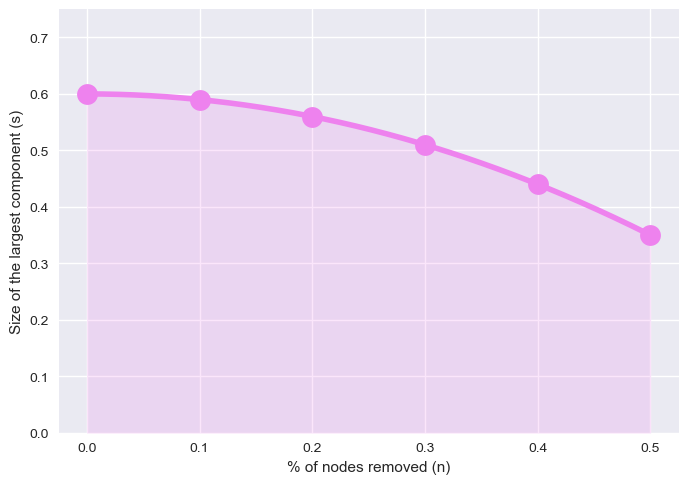

In [26]:
# Create the same simulated plot but pink with a thicker line to be viewed in methods graphic

# Simulate the data
x = np.linspace(0, 0.5, 6)  # Fraction of nodes removed
y = 0.6 - x**2  # Size of the largest component

# Create the plot
fig, ax = plt.subplots()

# Plot the data points
ax.plot(x, y, 'o', color='violet', markersize = 15)

# Create a smooth curve through the points
xnew = np.linspace(x.min(), x.max(), 500) 
spl = make_interp_spline(x, y, k=3)
y_smooth = spl(xnew)

# Plot the smooth curve
ax.plot(xnew, y_smooth, color='violet', linewidth = 4)

# Fill the area below the curve
ax.fill_between(xnew, y_smooth, color='violet', alpha=0.2)

# Set x max
ax.set_ylim(0, 0.75)

# Set the labels
ax.set_xlabel('% of nodes removed (n)')
ax.set_ylabel('Size of the largest component (s)')

plt.style.use('seaborn-white')
plt.grid(True)

# Show the plot
plt.show()
